# **Bank Customer Attrition Insights**: Case Study
*Bank Customer Dataset for Predicting Customer Churn*

## **Step 1: Understand The Problem**

**Objective**: Predict whether customers will leave the bank (churn) based on their attributes and behaviors.

**Target Variables**: *Exited* (1 = Customer left, 0 = Customer stayed).

**About The Data**
The XYZ Multistate Bank dataset analyzes customer behavior and attributes to predict churn. Containing various columns, it offers insights into factors influencing customer retention. Each column captures key aspects of customer interactions and demographics, aiming to identify customers at high risk of leaving the bank. By understanding these influencing factors, the bank can proactively implement retention strategies and improve customer loyalty. This dataset is crucial for developing predictive models to minimize churn and maximize customer lifetime value.

In this dataset, there are 10000 rows, 18 columns, and these variables.

*Data from Kaggle.com, dataset by [Sagar Maru](https://www.kaggle.com/datasets/marusagar/bank-customer-attrition-insights)*

Variable | Description |
---| ---|
RowNumber| numeric identifier (not a factor)
CustomerId| customer unique identifier (not a factor)
Surname|  holds the last names of customers (not a factor)
CreditScore| fico score of customer
Geography| geographical location of the customer
Gender| demographic of customer
Age| age of customer
Tenure| number of years a customer has been with the bank
Balance| amount of money a customer holds in their bank account
NumOfProducts| number of products (e.g., savings accounts, loans, credit cards) that a customer has with the bank
HasCrCard| indicates whether or not a customer holds a credit card with the bank
IsActiveMember| indicates whether a customer actively engages with the bank's services
EstimatedSalary| customer’s estimated annual salary
Exited| customer has left the bank (1) or remained (0)
Complain| whether or not a customer has filed a complaint with the bank
Satisfaction Score| how satisfied a customer is with the bank's complaint resolution process
Card Type| type of credit card a customer holds, such as a standard, premium, or rewards card
Points Earned| loyalty points a customer has accumulated through the use of their credit card


## **Step 2: Set Up Your Environment**

In [171]:
# 1. Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree


In [172]:
#2. Load and Explore the Data

df=pd.read_csv("Bank-Customer-Attrition-Insights-Data.csv")

print("done")

done


## **Step 3: Load and Explore the Data**

In [174]:
df.head() # View the first few rows

#format for satisfaction score, card type and point earned have spaces
#format will be all lower case

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15598695,Fields,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15649354,Johnston,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15737556,Vasilyev,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15671610,Hooper,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15625092,Colombo,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [175]:
df.info() # Check for missing values and data type

# 1000 variables, 18 columns
# float(2) Balance, EstimatedSalary
# int(12) CreditScore, Age, Tenure, Numofproducts, HasCrCard, IsActiveMember, Exited, Complain, Satisfaction Score, Point Earned
# object(4) Surname, Geography, Gender, Card Type

# No missing values, maybe dups?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [176]:
df.describe() # Summary of statistics

# Estimated salary 25% lower income than 100k 
# Half of the customers have left
# Oldest customer is 92 years old and younges is 18.
# 50% of customers have an average of 650 fico score
# credit score min is 350?
# low number of product with max of 4

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


## **Step 4: Data Cleaning**
**Distribution of Features**
* What is the distribution of each feature?
* Are there any outliers or unusual patterns?
* Create visualizations to see if it would be helpful.

In [178]:
# 1. drop irrelevant Columns

df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [179]:
# 2. Confirm there is no missing value
df.isnull().sum()

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [180]:
# Confirm there is no duplications
df.duplicated().sum()

0

In [181]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')

In [182]:
# Renaming to lower cap and correcting column name
df=df.rename(columns=str.lower)

In [183]:
df=df.rename(columns={'satisfaction score':'satisfaction_score',
              'card type':'card_type', 
              'point earned':'point_earned'})
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited', 'complain', 'satisfaction_score', 'card_type',
       'point_earned'],
      dtype='object')

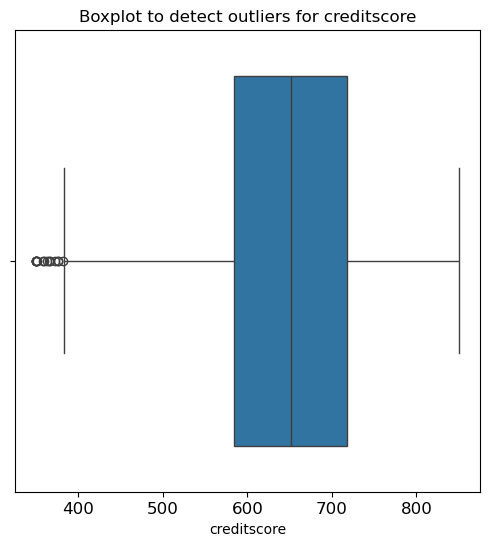

In [184]:
#Checking for outliers for credit score

plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for creditscore', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x='creditscore', data=df)
plt.show()

In [282]:
# Investigating outliers for creditscore

# Determining how many outliers are in the row of creditscore
percent25 = df['creditscore'].quantile(0.25)
percent75 = df['creditscore'].quantile(0.75)

iqr = percent75-percent25

c_upper_limit = percent75 + 1.5 * iqr
c_lower_limit = percent25 - 1.5 * iqr
print("Anything Above is an outlier:", c_upper_limit)
print("Anything Below is an outlier:", c_lower_limit)

outliers =  df[(df['creditscore'] > c_upper_limit) | (df['creditscore'] < c_lower_limit)]
print("Number of rows containing data with outliers in creditscore:", len(outliers))

Anything Above is an outlier: 919.0
Anything Below is an outlier: 383.0
Number of rows containing data with outliers in creditscore: 15


In [186]:
# Investigate the creditscore outliers
print("Investigating CreditScore outliers:\n", outliers[['creditscore']].describe())  # Get summary statistics

Investigating CreditScore outliers:
        creditscore
count    15.000000
mean    361.333333
std      11.362009
min     350.000000
25%     350.000000
50%     359.000000
75%     370.000000
max     382.000000


**Credit score Outliers Insight**

Outliers in creditscore are real data points that represent truly extreme cases. For example, low credit scores due to age or number of products such as credit cards, savings, etc. There aren't any unusual numbers indicating errors but is good to investigate why values are flagged as outliers.

---

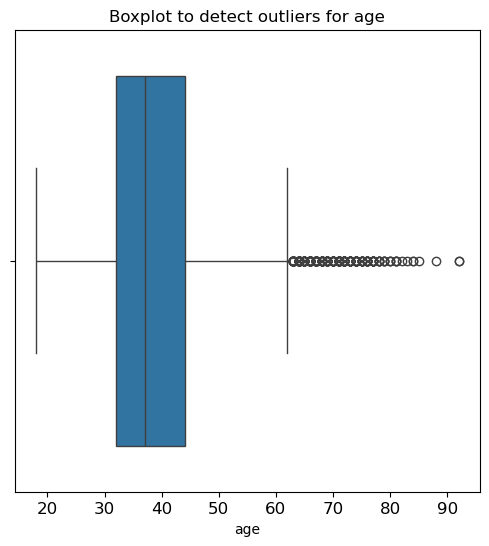

In [188]:
#Checking for outliers for age

plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for age', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x='age', data=df)
plt.show()

In [286]:
# Determining how many outliers are in the row of age
percent25 = df['age'].quantile(0.25)
percent75 = df['age'].quantile(0.75)

iqr = percent75-percent25

a_upper_limit = percent75 + 1.5 * iqr
a_lower_limit = percent25 - 1.5 * iqr
print("Anything Above is an outlier:", a_upper_limit)
print("Anything Below is an outlier:", a_lower_limit)

outliers =  df[(df['age'] > a_upper_limit) | (df['age'] < a_lower_limit)]
print("Number of rows containing data with outliers in age:", len(outliers))

Anything Above is an outlier: 62.0
Anything Below is an outlier: 14.0
Number of rows containing data with outliers in age: 359


In [190]:
# Investigate the age outliers
print("Investigating Age outliers:\n", outliers[['age']].describe())  # Get summary statistics

Investigating Age outliers:
               age
count  359.000000
mean    69.270195
std      5.237059
min     63.000000
25%     65.000000
50%     68.000000
75%     72.000000
max     92.000000


**Age Outliers Insight**

There are 359 outliers and most are skewed to the left. This could mean accounts might need to be deactivated or other potential factors. 
It may be good to investigate age further with other variables.

---

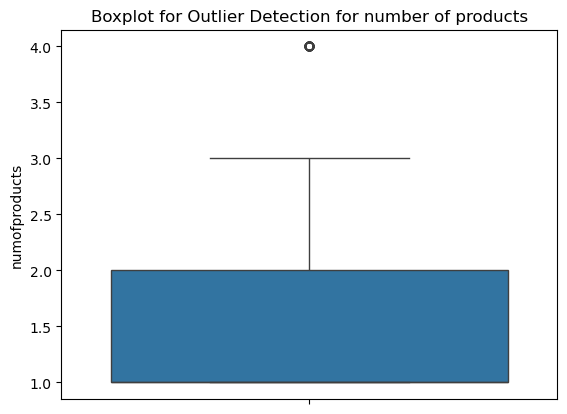

In [192]:
# Checking for outliers for numofproducts
sns.boxplot(y=df['numofproducts'])
plt.title('Boxplot for Outlier Detection for number of products')
plt.show()

In [193]:
# Determining how many outliers are in the row of numofproducts
percent25 = df['numofproducts'].quantile(0.25)
percent75 = df['numofproducts'].quantile(0.75)

iqr = percent75-percent25

upper_limit = percent75 + 1.5 * iqr
lower_limit = percent25 - 1.5 * iqr
print("Anything Above is an outlier:", upper_limit)
print("Anything Below is an outlier:", lower_limit)

outliers =  df[(df['numofproducts'] > upper_limit) | (df['numofproducts'] < lower_limit)]
print("Number of rows containing data with outliers in numofproducts:", len(outliers))

Anything Above is an outlier: 3.5
Anything Below is an outlier: -0.5
Number of rows containing data with outliers in numofproducts: 60


In [194]:
# Investigate the numofproducts outliers
print("Investigating NumOfProducts outliers:\n", outliers[['numofproducts']].describe())  # Get summary statistics

Investigating NumOfProducts outliers:
        numofproducts
count           60.0
mean             4.0
std              0.0
min              4.0
25%              4.0
50%              4.0
75%              4.0
max              4.0


**NumOfProducts Outliers Insight**

There are 60 outliers in numofproducts with a left-skewed however data points represent 4 being the max. The outliers seem genuine but it is good to compare with another variable to determine the possibility of churn.

---

## **Step 5: Exploratory Data Analysis (EDA)**
**Correlation Analysis**
* What are the correlations between the different features and the target variable "Exited"?
* Are there any strong positive or negative correlations?
* A correlation matrix would be useful.

*reminder: 1 means left and 0 means stay*

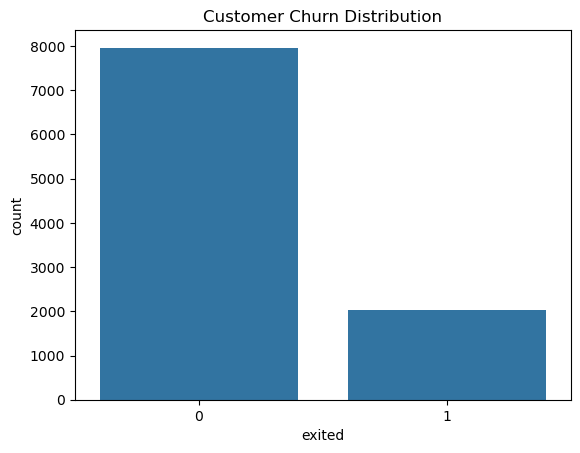

In [197]:
# 1. Visualize the distribution of the target variable
sns.countplot(x='exited', data=df)
plt.title('Customer Churn Distribution')
plt.show()

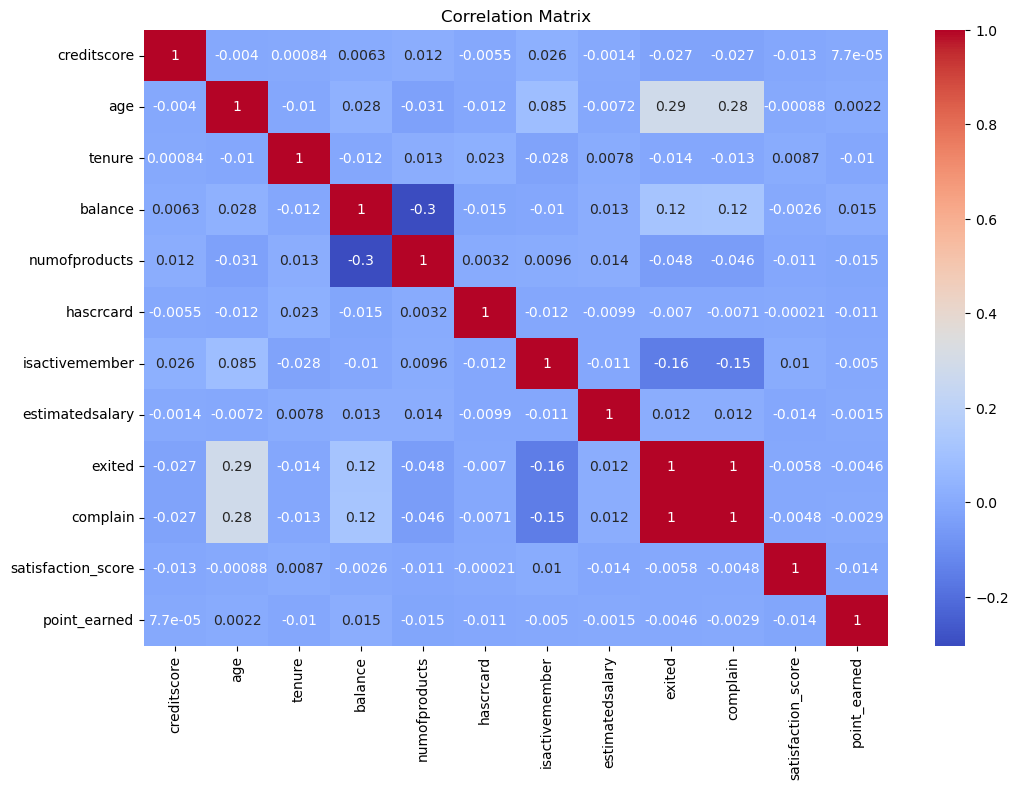

In [198]:
# 2. Analyze Correlations with numeric_df

numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In this Correlation Matrix, three observations that catch my attention:
1. creditscore and age, are very close to 0 and suggest no linear relationship between the customer's age and credit score.
2. age and exited, correlation is 0.29 which means when a customer's age increases, the likelihood of exiting tends to increase.
3. balance and numofproducts, correlation is -0.3 suggesting balance increases while the number of products tends to decrease, and vice versa.

It is good to investigate variables close to 1 and -1, potentially absolute values greater than 0.5, as they indicate stronger relationships such as:
* tenure vs age
* tenure vs points_earned
* balance vs numofproducts
* balance vs isactivemember
* isactivemember vs satisfaction_score
* isactivemember vs point_earned

In [200]:
# 3. Explore key features

# Getting value counts in stayed and exited for customers
print(df['exited'].value_counts())
print()

print(df['exited'].value_counts(normalize=True))

exited
0    7962
1    2038
Name: count, dtype: int64

exited
0    0.7962
1    0.2038
Name: proportion, dtype: float64


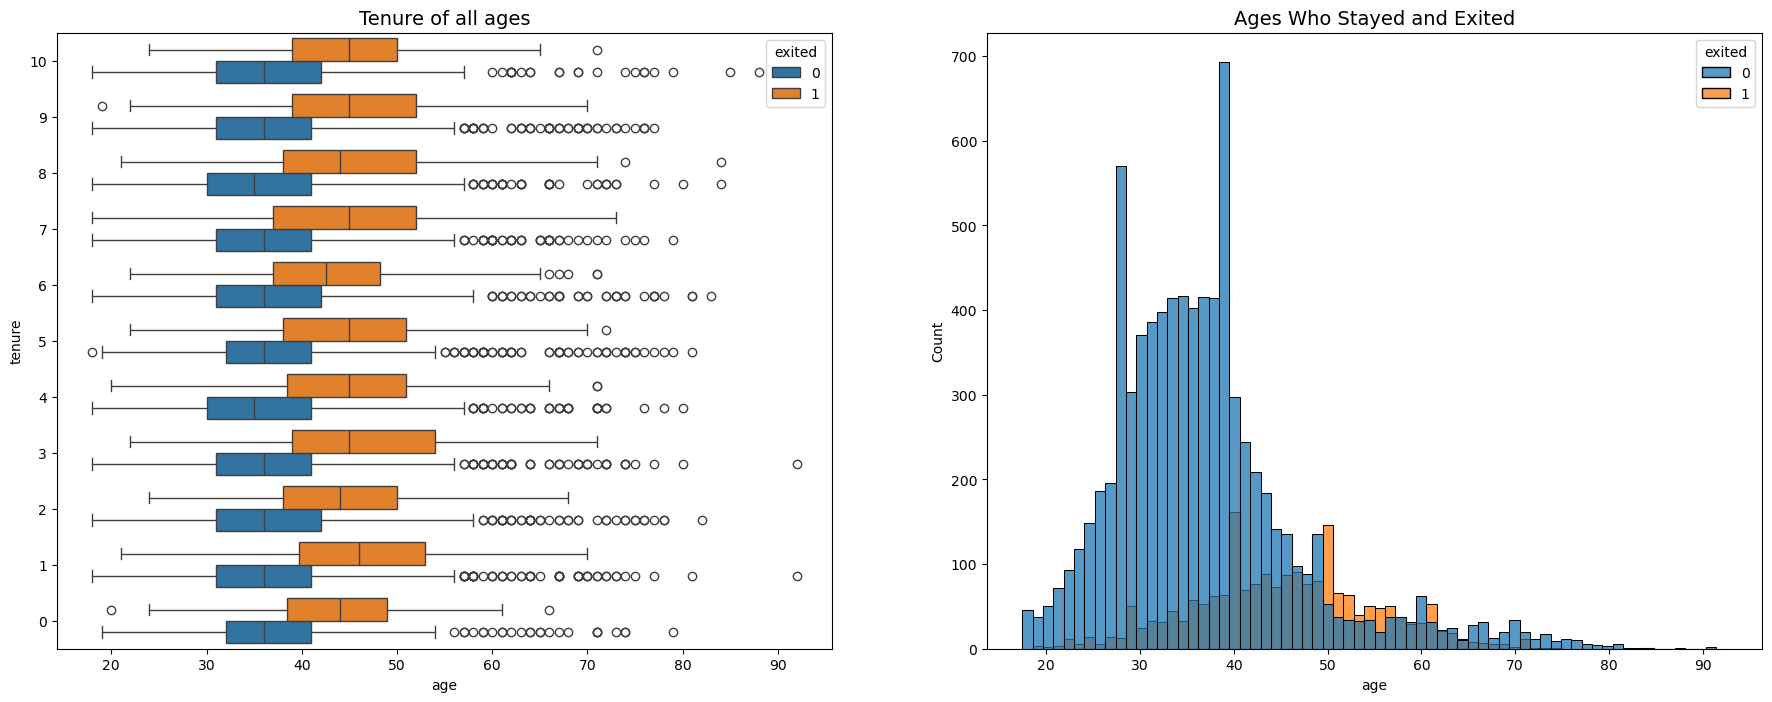

In [201]:
# Creating a box plot and histogram for tenure and age
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Creating a boxplot showing 'age' distribution for 'tenure', comparing churn
sns.boxplot(data=df, x='age', y='tenure', hue='exited', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Tenure of all ages', fontsize='14')

# Creating histogram showing distribution of 'age', comparing churn
sns.histplot(data=df, x='age', hue='exited', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Ages Who Stayed and Exited', fontsize='14')

plt.show()

It might be normal for a range of age groups to stay with a bank due to investments, mortgages, retirement planning, etc. It appears to be the case here, however, life stages and financial changes can happen. A few things stand out from this plot.
* The ages between 30-40, vary in tenure. This could be an example of products available and/or better offers from competitors.
* The age 50+ are leaving probably due to technical difficulties, health issues, children taking over, etc. Another possibility, is poor customer service, lack of personalized service, or relocation.
* The age of 50+ should be investigated due to inactive accounts causing the data to fluctuate from true results.

The average retirement age in Europe to receive a pension is 65-67. Questions to ask are:
1. How many customers are active based on age?
2. How many active customers have cards and earning points?
3. Are customers satisfied vs complaints?

In [203]:
# Getting value counts in active and nonactive for customers

print(df['isactivemember'].value_counts())
print()

print(df['isactivemember'].value_counts(normalize=True))

# Half of the customers are active

isactivemember
1    5151
0    4849
Name: count, dtype: int64

isactivemember
1    0.5151
0    0.4849
Name: proportion, dtype: float64


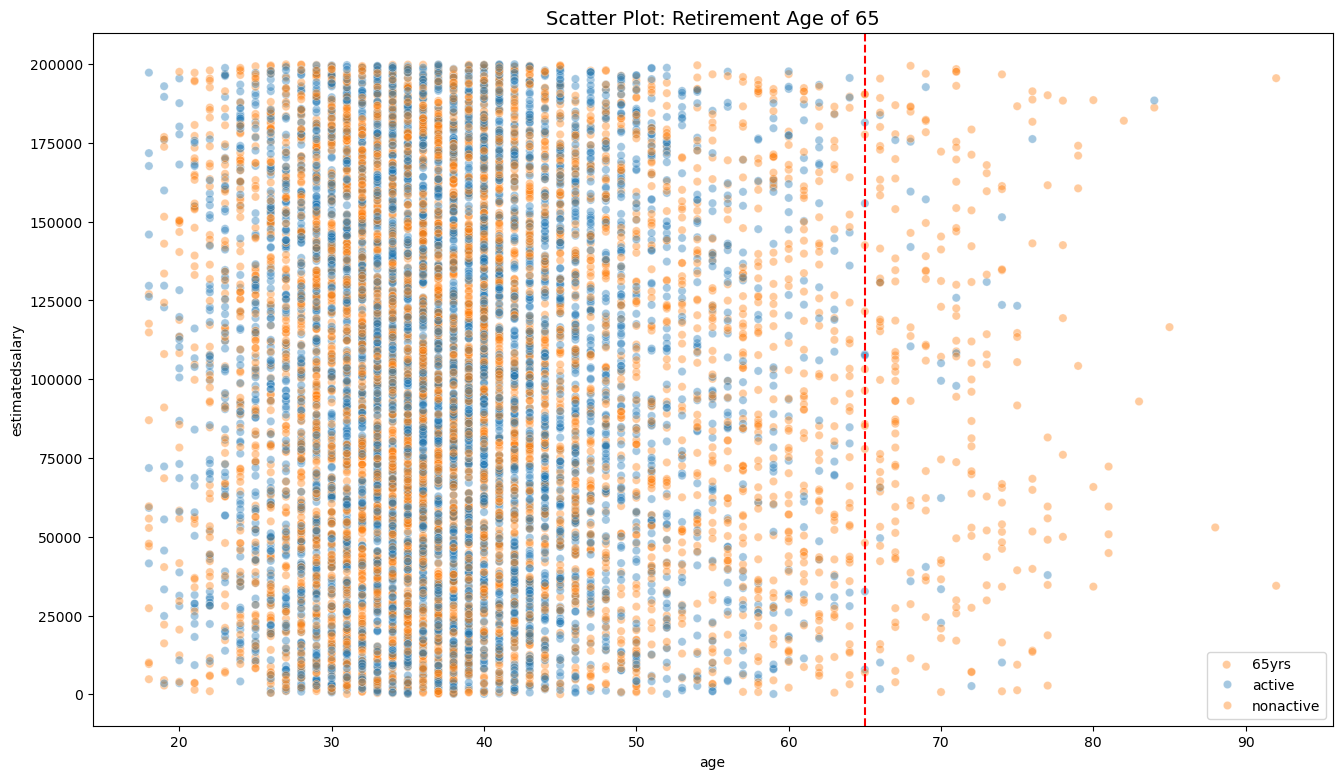

In [204]:
# Creating a scatter plot of age vs salary based on active and nonactive members

plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='age', y='estimatedsalary', hue='isactivemember', alpha=0.4)
plt.axvline(x=65, color='red', label='65yrs', linestyle='--')
plt.legend(labels=['65yrs', 'active', 'nonactive'])
plt.title('Scatter Plot: Retirement Age of 65', fontsize='14');

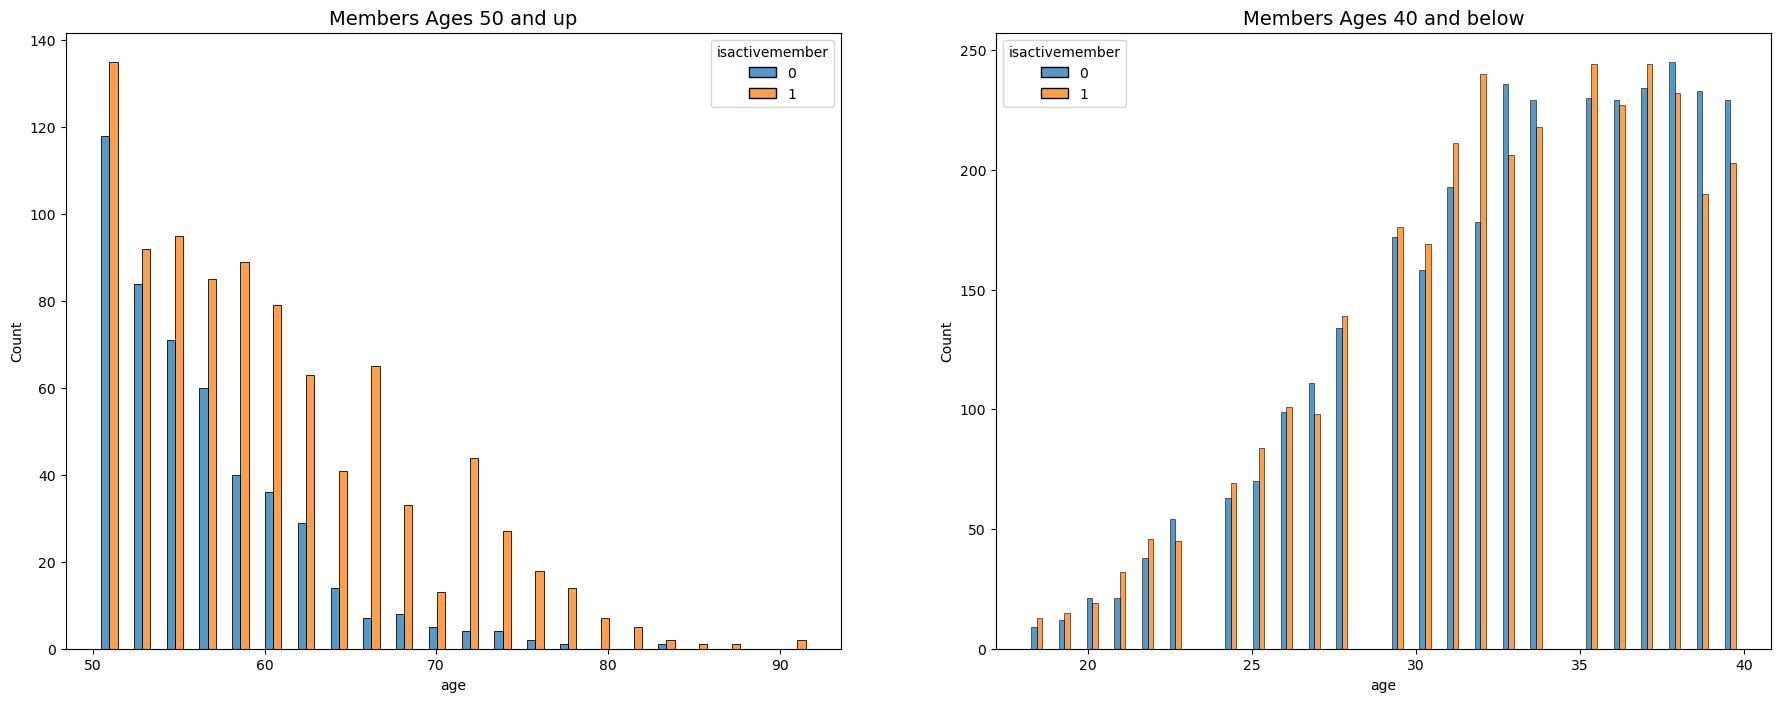

In [205]:
# How many active and nonactive members based on age?
fig, ax = plt.subplots(1, 2, figsize = (22,8))

upper_age = df[df['age'] >= 50]
lower_age = df[df['age'] <= 40]

sns.histplot(data=upper_age, x='age', hue='isactivemember', multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Members Ages 50 and up', fontsize='14')

sns.histplot(data=lower_age, x='age', hue='isactivemember',multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Members Ages 40 and below', fontsize='14');

In this observation between age range for active and nonactive members, a few things stand out:

How many active and nonactive members are based on age?
* The age of 50+ accounts are becoming inactive. The potential increase in elderly offers should be increased.
* Ages 40 and below are similar in active and nonactive this could mean there may be better offers somewhere else. It seems money is being moved somewhere else regardless of age.

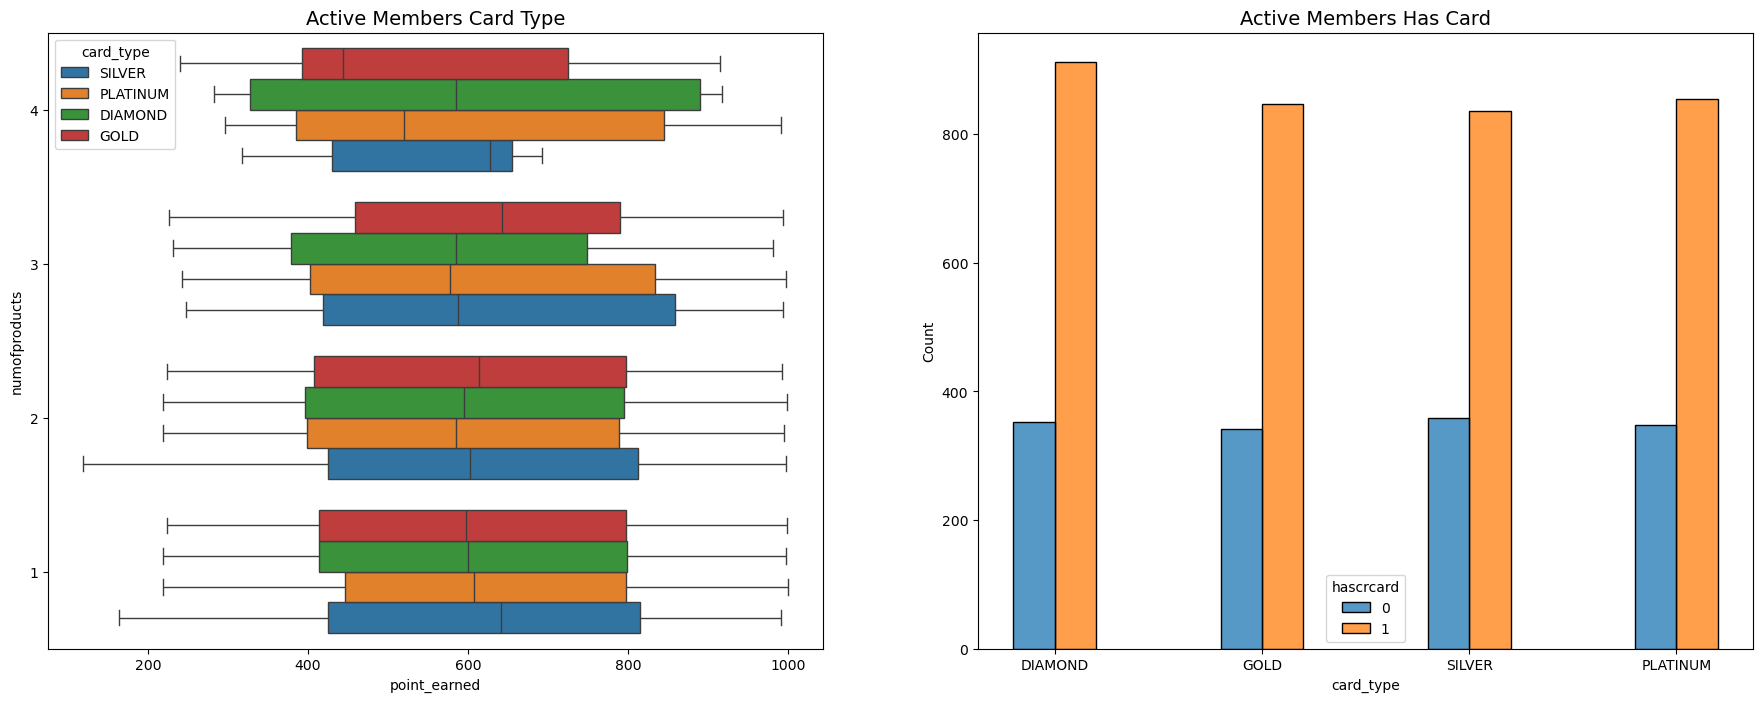

In [207]:
# How many active customers have cards and earn points?

fig, ax = plt.subplots(1, 2, figsize = (22,8))

active_member = df[df['isactivemember'] == 0]
nonactive_member = df[df['isactivemember'] == 1]

sns.boxplot(data=active_member, x='point_earned', y='numofproducts', hue='card_type',orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Active Members Card Type', fontsize='14')

sns.histplot(data=active_member, x='card_type', hue='hascrcard', multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Active Members Has Card', fontsize='14');

plt.show()

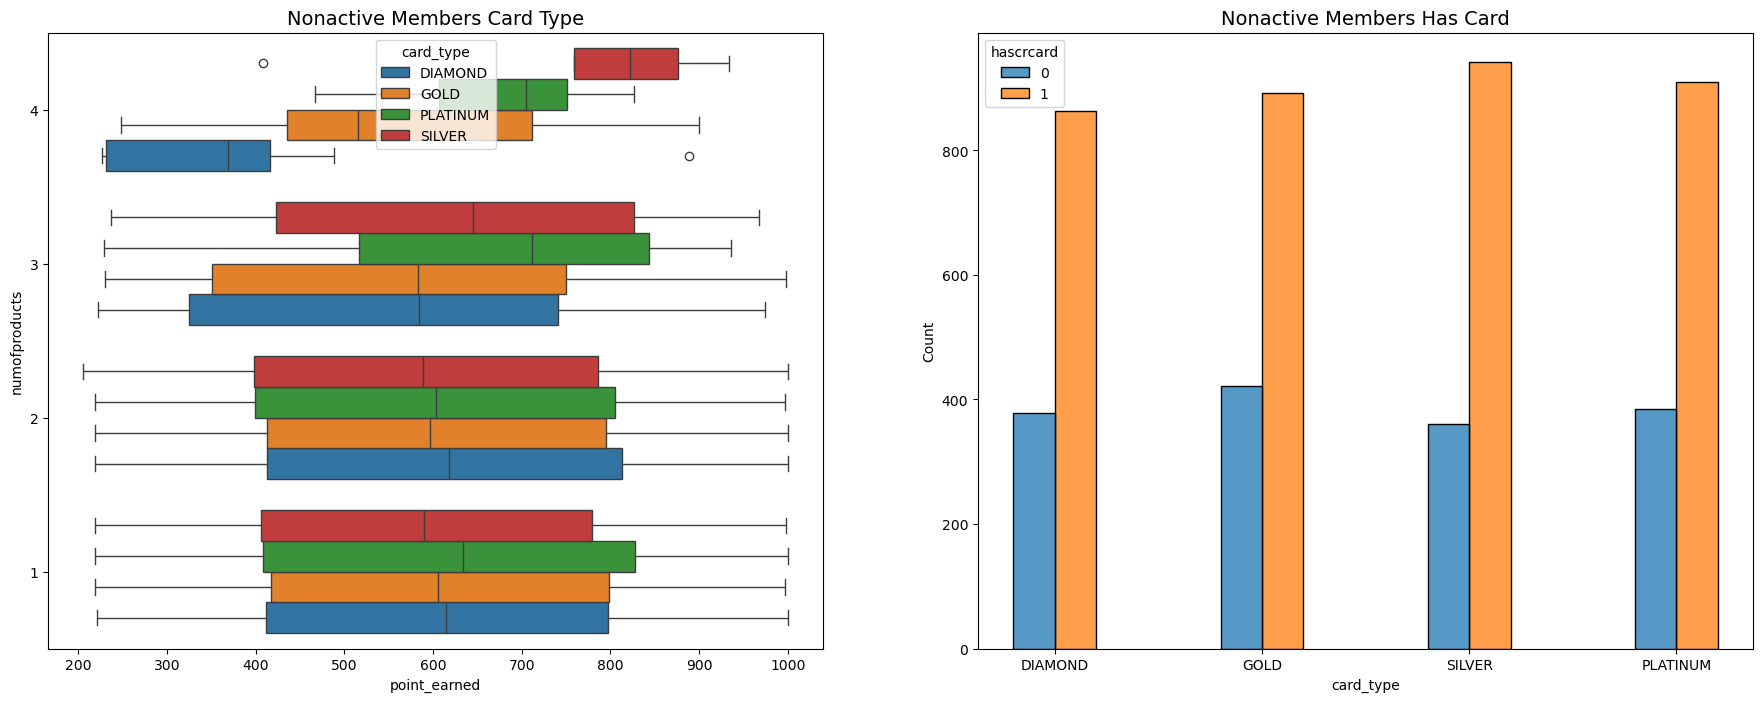

In [208]:
# How many nonactive customers have cards and earn points?

fig, ax = plt.subplots(1, 2, figsize = (22,8))

active_member = df[df['isactivemember'] == 0]
nonactive_member = df[df['isactivemember'] == 1]

sns.boxplot(data=nonactive_member, x='point_earned', y='numofproducts', hue='card_type',orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Nonactive Members Card Type', fontsize='14')

sns.histplot(data=nonactive_member, x='card_type', hue='hascrcard', multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Nonactive Members Has Card', fontsize='14');

plt.show()

In this observation, a few things stand out.

As a reminder:
1. PLATINUM: Typically the highest tier. It signifies premium quality, exclusivity, or the most comprehensive benefits.
2. DIAMOND: Often the second-highest tier. It still represents high value and desirable benefits but may be slightly less exclusive or comprehensive than Platinum.
3. GOLD: A mid-level tier, representing good value and a decent set of benefits. It's often a balance between cost and quality.
4. SILVER: A lower tier, usually the most accessible. It provides basic benefits or a starting point for membership.

How many active and nonactive customers have cards and earn points?
* An estimated count of 400 customers do not have either card, which should be promoted through customer service.
* Earned points look stagnant, between 400-800 points where the max is 10,000. An increase in benefits can increase the likelihood of earned points continuing the loyalty of customers.

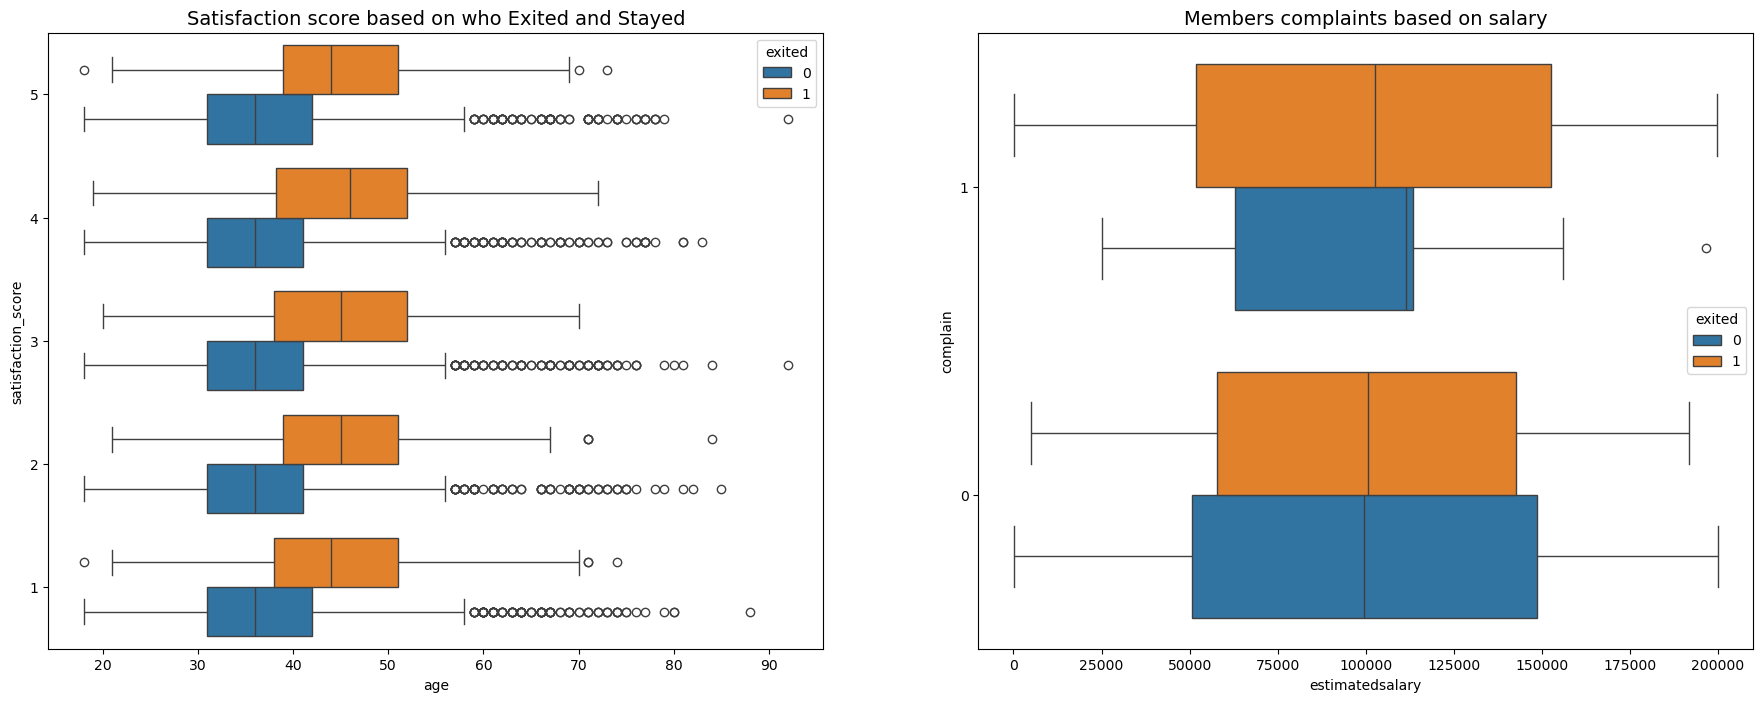

In [210]:
# Are customers satisfied vs complaints?

fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df, x='age', y='satisfaction_score', hue='exited',orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction score based on who Exited and Stayed', fontsize='14')

sns.boxplot(data=df, x='estimatedsalary', y='complain', hue='exited',orient="h", ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Members complaints based on salary', fontsize='14');

plt.show()

In this observation, a few things stand out:

* The satisfaction score increased by 30 however ages 40 and up still exited even though the satisfaction score was high.
* Customers who complained the most had a higher income.

**Insights**

It appears that customers have the income to continue banking but are leaving due to a lack of benefits especially as age increases. It also appears customers with higher incomes have more complaints. Leaving is tied to the number of products, earning points, and complaints even when the satisfaction scores are high. The potential of better offers from competitors, poor customer service, and lack of personalized benefits could be the case for all ages of members exiting. 

---

## **Step 6: Feature Engineering**

**Objective**: Predict whether customers will leave the bank (churn) based on their attributes and behaviors involved with binary classification.

**Model Building**: Logistic Regression Model

*Reminder: Logistic Regression Model cannot have outliers*

In [252]:
# 1. Copy the dataframe

df_enc = df.copy()

In [256]:
# 2. Encode the non-numeric Variables

df_enc.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index(['geography', 'gender', 'card_type'], dtype='object')


In [258]:
df_enc['geography'].value_counts()

geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [260]:
df_enc['gender'].value_counts()

gender
Male      5457
Female    4543
Name: count, dtype: int64

In [262]:
df_enc['card_type'].value_counts()

card_type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64

In [264]:
# Encode the `geography` column as an ordinal numeric category
df_enc['geography'] = (
    df_enc['geography'].astype('category')
    .cat.set_categories(['France','Germany','Spain'])
    .cat.codes
)

# Dummy encode the `gender` and `card_type` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,point_earned,gender_Female,gender_Male,card_type_DIAMOND,card_type_GOLD,card_type_PLATINUM,card_type_SILVER
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,2,464,True,False,True,False,False,False
1,608,2,41,1,83807.86,1,0,1,112542.58,0,1,3,456,True,False,True,False,False,False
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,3,377,True,False,True,False,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,5,350,True,False,False,True,False,False
4,850,2,43,2,125510.82,1,1,1,79084.10,0,0,5,425,True,False,False,True,False,False


In [305]:
df_enc['totalproducts'] = df_enc['numofproducts'] + df_enc['hascrcard']

In [309]:
scaler = StandardScaler()
df[['creditscore', 'age', 'balance', 'estimatedsalary']] = scaler.fit_transform(df[['creditscore', 'age', 'balance', 'estimatedsalary']])

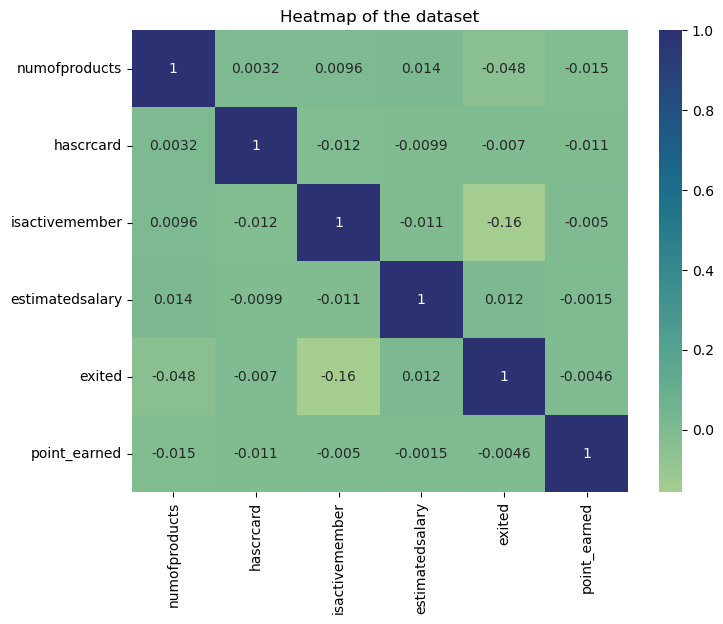

In [313]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['numofproducts','hascrcard', 'isactivemember', 'estimatedsalary', 'exited','point_earned']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

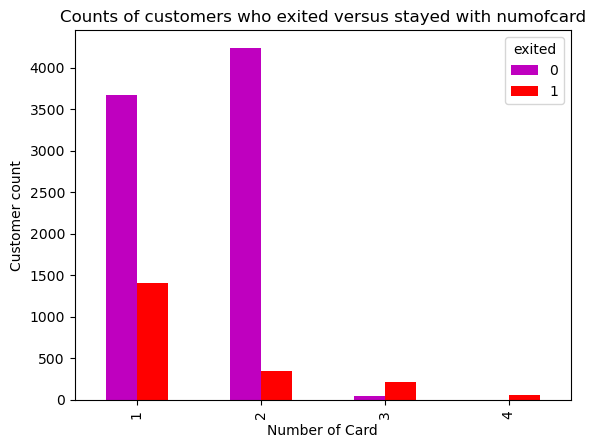

In [280]:
pd.crosstab(df['numofproducts'], df['exited']).plot(kind ='bar',color='mr')
plt.title('Counts of customers who exited versus stayed with numofcard')
plt.ylabel('Customer count')
plt.xlabel('Number of Card')
plt.show()

In [339]:
# Select rows without outliers in creditscore, age, numofproducts and save resulting dataframe in a new variable
limits = {
    'creditscore': {'lower': c_lower_limit, 'upper': c_upper_limit},
    'age': {'lower': a_lower_limit, 'upper': a_upper_limit},
    'numofproducts': {'lower': lower_limit, 'upper': upper_limit}
}

combined_filter = pd.Series(True, index=df_enc.index)

for column, lims in limits.items():
    lower_limit = lims['lower']
    upper_limit = lims['upper']
    column_filter = (df_enc[column] >= lower_limit) & (df_enc[column] <= upper_limit)
    combined_filter = combined_filter & column_filter  # Combine with AND

df_logreg = df_enc[combined_filter]
print(df_logreg)


      creditscore  geography  age  tenure    balance  numofproducts  \
0             619          0   42       2       0.00              1   
1             608          2   41       1   83807.86              1   
2             502          0   42       8  159660.80              3   
3             699          0   39       1       0.00              2   
4             850          2   43       2  125510.82              1   
...           ...        ...  ...     ...        ...            ...   
9995          771          0   39       5       0.00              2   
9996          516          0   35      10   57369.61              1   
9997          709          0   36       7       0.00              1   
9998          772          1   42       3   75075.31              2   
9999          792          0   28       4  130142.79              1   

      hascrcard  isactivemember  estimatedsalary  exited  complain  \
0             1               1        101348.88       1         1   
1      

In [ ]:
df_logreg = df_enc[(df_enc['age'] >= a_lower_limit) & (df_enc['age'] <= a_upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

## **Step 7: Split the Data**

In [266]:
df_enc.columns

Index(['creditscore', 'geography', 'age', 'tenure', 'balance', 'numofproducts',
       'hascrcard', 'isactivemember', 'estimatedsalary', 'exited', 'complain',
       'satisfaction_score', 'point_earned', 'gender_Female', 'gender_Male',
       'card_type_DIAMOND', 'card_type_GOLD', 'card_type_PLATINUM',
       'card_type_SILVER'],
      dtype='object')

In [341]:
# Isolate the outcome variable
y = df_logreg['exited']

# Display first few rows of the outcome variable
y.head() 

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

In [343]:
# Select the features you want to use in your model
X = df_logreg.drop('exited', axis=1)

# Display the first few rows of the selected features 
X.head()

,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction_score,point_earned,gender_Female,gender_Male,card_type_DIAMOND,card_type_GOLD,card_type_PLATINUM,card_type_SILVER,totalproducts
0,619,0,42,2,0.00,1,1,1,101348.88,1,2,464,True,False,True,False,False,False,2
1,608,2,41,1,83807.86,1,0,1,112542.58,1,3,456,True,False,True,False,False,False,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,3,377,True,False,True,False,False,False,4
3,699,0,39,1,0.00,2,0,0,93826.63,0,5,350,True,False,False,True,False,False,2
4,850,2,43,2,125510.82,1,1,1,79084.10,0,5,425,True,False,False,True,False,False,2


In [345]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## **Step 8: Build and Train a Model**

In [347]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear').fit(X_train, y_train)

## **Step 9: Evaluate the Model**

In [349]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

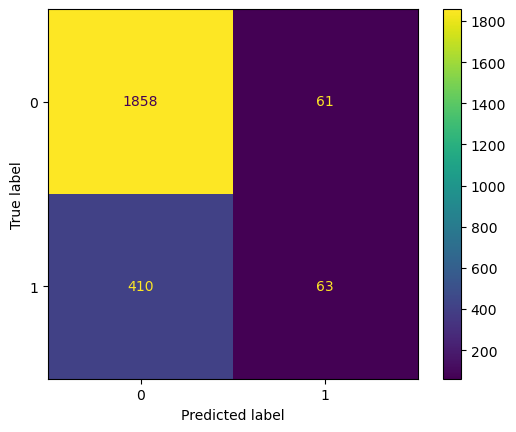

In [351]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [353]:
df_logreg['exited'].value_counts(normalize=True)

exited
0    0.802258
1    0.197742
Name: proportion, dtype: float64

In [355]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.82      0.97      0.89      1919
    Predicted would leave       0.51      0.13      0.21       473

                 accuracy                           0.80      2392
                macro avg       0.66      0.55      0.55      2392
             weighted avg       0.76      0.80      0.75      2392

